## Extended Data Figure 6

Genetic Interaction gene MSE

In [1]:
### Script for computing linear model parameter for GI subtype prediction
## Designed for the LOO training/testing strategy

import glob
import numpy as np
import torch
import scanpy as sc
import pandas as pd 
import copy
import sys
sys.path.append('../../gears_misc/')
import os
#from data import PertDataloader
#from inference import evaluate, compute_metrics
from scipy.stats import pearsonr, spearmanr
from gears.inference import GIs
import seaborn as sns
from fig_utils import *

# Linear model fitting functions
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score

## Model inference functions

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hi_umi+hvg.h5ad')
all_conditions = adata.obs['condition'].unique()

### GI genes MSE

In [3]:
def get_GI_type(gi_name):
    return [k for k in GIs.keys() if gi_name in GIs[k]][0].lower()

def get_GI_mse(files, type_):
    results = []
    for f in files:
        try:
            if type_ == 'gears':
                gi_name = f.split('seed')[0].split('/')[-1]
            elif type_ == 'cpa':
                gi_name = f.split('/')[-1].split('.npy')[0]
            gi_type = get_GI_type(gi_name)
            loaded = np.load(f, allow_pickle=True).item()
            loaded['pred_pearson'] = loaded['pred_pearson'][0]
            loaded['naive_pearson'] = loaded['naive_pearson'][0]
            loaded['GI_type'] = gi_type
            loaded_df = pd.DataFrame.from_dict(loaded, orient='index', columns=[gi_name]).T
            results.append(loaded_df)
        except:
            print(f)
        
    return pd.concat(results)

In [4]:
# Get GEARS DF (Seen 2)
GI_genes_out = glob.glob('/dfs/user/yhr/gears2/Evaluation/GI_gene_mse/*seed2.npy')
pertnet_df = get_GI_mse(GI_genes_out, type_='gears')
pertnet_df['model'] = 'gears'
means = pertnet_df.groupby('GI_type').mean(0)
stds = pertnet_df.groupby('GI_type').agg(lambda x: np.std(x, ddof=1))

In [5]:
# Get Naive DF

naive_cols = [c for c in pertnet_df.columns if 'naive' in c] + ['GI_type']
naive_df = pertnet_df.loc[:,naive_cols]
naive_df['model']='naive'
naive_df = naive_df.rename(columns= {'naive_mse':'pred_mse',
                          'naive_pearson':'pred_pearson',
                          'naive_precision_at_10_10':'precision_at_10_10',
                          'naive_precision_at_5_5':'precision_at_5_5',
                          'naive_precision_at_5_25':'precision_at_5_25',})

In [6]:
# Get CPA DF

GI_genes_out = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_gene_mse/*.npy')
cpa_df = get_GI_mse(GI_genes_out, type_='cpa')
cpa_df['model'] = 'cpa'
cpa_df.groupby('GI_type').mean(0)

,pred_mse,pred_pearson,naive_mse,naive_pearson,naive_precision_at_10_10,precision_at_10_10,naive_precision_at_5_5,precision_at_5_5,naive_precision_at_5_25,precision_at_5_25
GI_type,,,,,,,,,,
additive,0.116103,0.875056,0.107426,0.881688,0.275000,0.275000,0.325000,0.275000,0.525000,0.450000
epistasis,0.102632,0.852133,0.119281,0.882031,0.222222,0.288889,0.177778,0.288889,0.355556,0.444444
neomorphic,0.058252,0.769961,0.170841,0.770699,0.330769,0.361538,0.384615,0.276923,0.553846,0.446154
potentiation,0.259833,0.925770,0.261227,0.921214,0.200000,0.100000,0.200000,0.033333,0.333333,0.066667
redundant,0.294972,0.927458,0.256626,0.952996,0.500000,0.462500,0.350000,0.300000,0.700000,0.600000
suppressor,0.034271,0.830972,0.174208,0.801115,0.416667,0.425000,0.466667,0.433333,0.700000,0.633333
synergy_dissimilar_pheno,0.150957,0.811878,0.118950,0.804746,0.107692,0.107692,0.107692,0.092308,0.153846,0.184615
synergy_similar_pheno,0.211818,0.912079,0.125250,0.894310,0.336364,0.181818,0.200000,0.200000,0.545455,0.436364


In [7]:
gi_map = {g:g for g in pertnet_df['GI_type'].unique()}
gi_map['synergy_dissimilar_pheno']='synergy'
gi_map['synergy_similar_pheno']='synergy'
gi_map['potentiation']='synergy'
pertnet_df['GI_type'] = pertnet_df['GI_type'].map(gi_map)
cpa_df['GI_type'] = cpa_df['GI_type'].map(gi_map)
naive_df['GI_type'] = naive_df['GI_type'].map(gi_map)

In [8]:
ticklabel_map = {'epistasis':'Epistatis',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'suppressor':'Suppression',
                 'synergy': 'Synergy',
                 'additive':'Additive'}

### Seen 2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


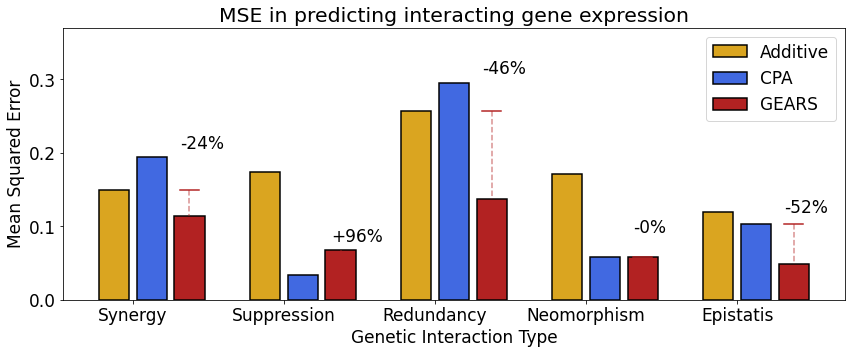

In [13]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

plot_df = pertnet_df[pertnet_df['GI_type']!='other']
plot_df2 = cpa_df[cpa_df['GI_type']!='other']

plot_df = plot_df[plot_df['GI_type']!='additive']
plot_df2 = plot_df2[plot_df2['GI_type']!='additive']
#plot_df = pertnet_df
#plot_df2 = cpa_df


plot_df2 = plot_df2.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]
plot_df = plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]

keys = np.sort(plot_df.index)[::-1]

fig = plt.figure(figsize=[14,5])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []

for itr, GI in enumerate(keys):
    
    ax.bar(itr*step, plot_df.loc[GI, 'naive_mse'], edgecolor='black', 
            linewidth=1.5,  color='goldenrod')
    ax.bar(itr*step+1, plot_df2.loc[GI, 'pred_mse'], edgecolor='black', 
            linewidth=1.5, color='royalblue')
    ax.bar(itr*step+2, plot_df.loc[GI, 'pred_mse'], edgecolor='black', 
            linewidth=1.5, color='firebrick')

plt.legend(['Additive', 'CPA', 'GEARS'], bbox_to_anchor=(1.0, 1.0))

for itr, GI in enumerate(keys):
    # Annotation
    line_bot = np.min([plot_df2.loc[GI, 'pred_mse'], plot_df.loc[GI, 'naive_mse']])
    #line_bot = plot_df2.loc[GI, 'pred_mse']
    line_top = plot_df.loc[GI, 'pred_mse']
    text_pos = (line_bot + line_top)/1.28
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([itr*step+2,itr*step+2],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.5)
    plt.plot([itr*step+1.75,itr*step+2.25],[line_bot,line_bot], color='firebrick')
    plt.annotate('{0:+.0f}%'.format(improve),(itr*step+1.75, text_pos))
    
    xticks.append(itr*step+0.5)
    xticklabels.append(GI)


plt.ylabel('Mean Squared Error')
plt.xlabel('Genetic Interaction Type')
plt.title('MSE in predicting interacting gene expression')

#_ = plt.xticks(xticks, ['' for x in xticklabels])
_ = plt.xticks(xticks, [ticklabel_map[x] for x in xticklabels])
plt.ylim([0,0.37])

plt.savefig('gi_mse.svg', bbox_inches='tight')

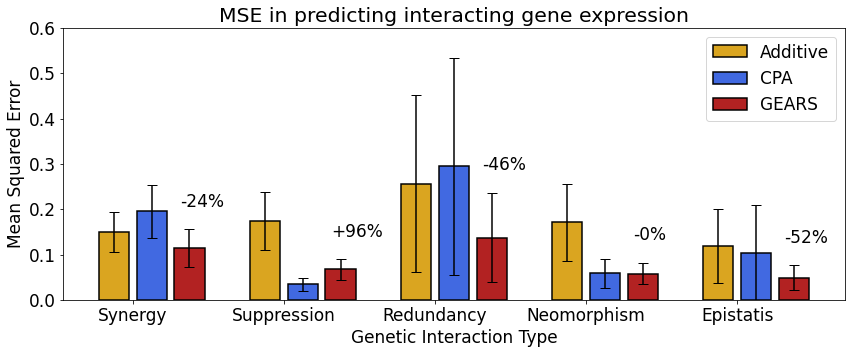

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

font = {'family': 'normal', 'size': 17}
matplotlib.rc('font', **font)

def compute_confidence_interval(data, confidence=0.95):
    """
    Compute the confidence interval for a given list of values.

    Parameters:
        data (list or numpy array): List of values.
        confidence (float, optional): Confidence level. Defaults to 0.95.

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """
    n = len(data)
    mean = np.mean(data)
    std_error = stats.sem(data)
    interval = stats.t.interval(confidence, n-1, loc=mean, scale=std_error)
    return interval

gears_plot_df = pertnet_df[pertnet_df['GI_type'] != 'other']
cpa_plot_df = cpa_df[cpa_df['GI_type'] != 'other']
naive_plot_df = naive_df[naive_df['GI_type'] != 'other']

gears_plot_df = gears_plot_df[gears_plot_df['GI_type'] != 'additive']
cpa_plot_df = cpa_plot_df[cpa_plot_df['GI_type'] != 'additive']
naive_plot_df = naive_plot_df[naive_plot_df['GI_type'] != 'additive']

gears_mean_df = gears_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]
cpa_mean_df = cpa_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]
naive_mean_df = naive_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse']]

keys = np.sort(gears_mean_df.index)[::-1]

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
gears_cis = []

for itr, GI in enumerate(keys):
    # Bar plots
    ax.bar(itr * step, naive_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='goldenrod')
    ax.bar(itr * step + 1, cpa_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='royalblue')
    ax.bar(itr * step + 2, gears_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='firebrick')

    # Error bars - Confidence Intervals
    gears_ci = compute_confidence_interval(gears_plot_df[gears_plot_df['GI_type']==GI]['pred_mse'].values)
    cpa_ci = compute_confidence_interval(cpa_plot_df[cpa_plot_df['GI_type']==GI]['pred_mse'].values)
    naive_ci = compute_confidence_interval(naive_plot_df[naive_plot_df['GI_type']==GI]['pred_mse'].values)
    
    gears_cis.append(gears_ci)

    ax.errorbar(itr * step, naive_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(naive_ci, naive_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)
    ax.errorbar(itr * step + 1, cpa_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(cpa_ci, cpa_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)
    ax.errorbar(itr * step + 2, gears_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(gears_ci, gears_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)

plt.legend(['Additive', 'CPA', 'GEARS'], bbox_to_anchor=(1.0, 1.0))


for itr, GI in enumerate(keys):
    # Annotation
    line_bot = np.min([plot_df2.loc[GI, 'pred_mse'], plot_df.loc[GI, 'naive_mse']])
    line_top = plot_df.loc[GI, 'pred_mse']
    text_pos = max(gears_cis[itr])+0.05
    improve = (line_top - line_bot) / line_bot * 100
    #plt.plot([itr * step + 2, itr * step + 2], [line_bot, line_top], color='firebrick', linestyle='--', alpha=0.5)
    #plt.plot([itr * step + 1.75, itr * step + 2.25], [line_bot, line_bot], color='firebrick')
    plt.annotate('{0:+.0f}%'.format(improve),(itr*step+1.75, text_pos))
    
    xticks.append(itr*step+0.5)
    xticklabels.append(GI)



plt.ylabel('Mean Squared Error')
plt.xlabel('Genetic Interaction Type')
plt.title('MSE in predicting interacting gene expression')

#_ = plt.xticks(xticks, ['' for x in xticklabels])
_ = plt.xticks(xticks, [ticklabel_map[x] for x in xticklabels])
plt.ylim([0,0.6])

plt.savefig('gi_mse.svg', bbox_inches='tight')


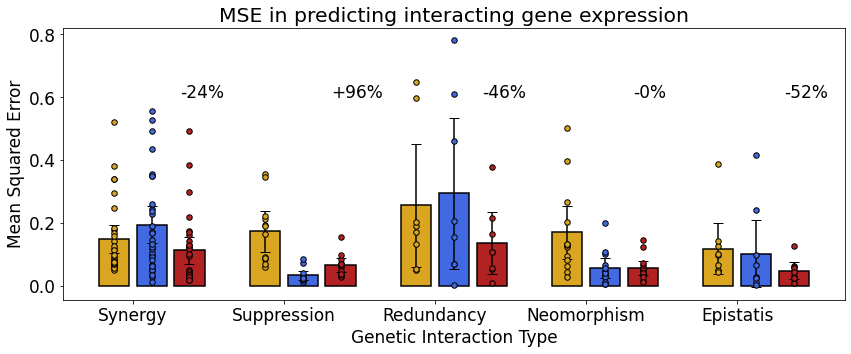

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib

font = {'family': 'normal', 'size': 17}
matplotlib.rc('font', **font)

def compute_confidence_interval(data, confidence=0.95):
    """
    Compute the confidence interval for a given list of values.

    Parameters:
        data (list or numpy array): List of values.
        confidence (float, optional): Confidence level. Defaults to 0.95.

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """
    n = len(data)
    mean = np.mean(data)
    std_error = stats.sem(data)
    interval = stats.t.interval(confidence, n-1, loc=mean, scale=std_error)
    return interval

gears_plot_df = pertnet_df[pertnet_df['GI_type'] != 'other']
cpa_plot_df = cpa_df[cpa_df['GI_type'] != 'other']
naive_plot_df = naive_df[naive_df['GI_type'] != 'other']

gears_plot_df = gears_plot_df[gears_plot_df['GI_type'] != 'additive']
cpa_plot_df = cpa_plot_df[cpa_plot_df['GI_type'] != 'additive']
naive_plot_df = naive_plot_df[naive_plot_df['GI_type'] != 'additive']

gears_mean_df = gears_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]
cpa_mean_df = cpa_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]
naive_mean_df = naive_plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse']]

keys = np.sort(gears_mean_df.index)[::-1]

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []
gears_cis = []

for itr, GI in enumerate(keys):
    # Bar plots
    ax.bar(itr * step, naive_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='goldenrod')
    ax.bar(itr * step + 1, cpa_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='royalblue')
    ax.bar(itr * step + 2, gears_mean_df.loc[GI, 'pred_mse'], edgecolor='black', linewidth=1.5, color='firebrick')

    # Error bars - Confidence Intervals
    gears_ci = compute_confidence_interval(gears_plot_df[gears_plot_df['GI_type']==GI]['pred_mse'].values)
    cpa_ci = compute_confidence_interval(cpa_plot_df[cpa_plot_df['GI_type']==GI]['pred_mse'].values)
    naive_ci = compute_confidence_interval(naive_plot_df[naive_plot_df['GI_type']==GI]['pred_mse'].values)
    
    gears_cis.append(gears_ci)

    ax.errorbar(itr * step, naive_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(naive_ci, naive_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)
    ax.errorbar(itr * step + 1, cpa_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(cpa_ci, cpa_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)
    ax.errorbar(itr * step + 2, gears_mean_df.loc[GI, 'pred_mse'],
                yerr=np.abs(np.subtract(gears_ci, gears_mean_df.loc[GI, 'pred_mse'])).reshape(2, 1),
                fmt='none', ecolor='black', capsize=5, linewidth=1.5)

    # Overlaying data points
    gears_data = gears_plot_df[gears_plot_df['GI_type'] == GI]['pred_mse']
    cpa_data = cpa_plot_df[cpa_plot_df['GI_type'] == GI]['pred_mse']
    naive_data = naive_plot_df[naive_plot_df['GI_type'] == GI]['pred_mse']

    ax.scatter(np.full_like(naive_data, itr * step), naive_data, color='goldenrod',
               edgecolor='black', zorder=5, s=30)
    ax.scatter(np.full_like(cpa_data, itr * step + 1), cpa_data, color='royalblue',
               edgecolor='black',  zorder=5, s=30)
    ax.scatter(np.full_like(gears_data, itr * step + 2), gears_data, color='firebrick',
               edgecolor='black',  zorder=5, s=30)


#plt.legend(['Additive', 'CPA', 'GEARS'], bbox_to_anchor=(1.0, 1.0))


for itr, GI in enumerate(keys):
    # Annotation
    line_bot = np.min([plot_df2.loc[GI, 'pred_mse'], plot_df.loc[GI, 'naive_mse']])
    line_top = plot_df.loc[GI, 'pred_mse']
    text_pos = 0.6
    improve = (line_top - line_bot) / line_bot * 100
    #plt.plot([itr * step + 2, itr * step + 2], [line_bot, line_top], color='firebrick', linestyle='--', alpha=0.5)
    #plt.plot([itr * step + 1.75, itr * step + 2.25], [line_bot, line_bot], color='firebrick')
    plt.annotate('{0:+.0f}%'.format(improve),(itr*step+1.75, text_pos))
    
    xticks.append(itr*step+0.5)
    xticklabels.append(GI)



plt.ylabel('Mean Squared Error')
plt.xlabel('Genetic Interaction Type')
plt.title('MSE in predicting interacting gene expression')

#_ = plt.xticks(xticks, ['' for x in xticklabels])
_ = plt.xticks(xticks, [ticklabel_map[x] for x in xticklabels])
#plt.ylim([0,0.6])

plt.savefig('gi_mse.svg', bbox_inches='tight')


### Seen 1

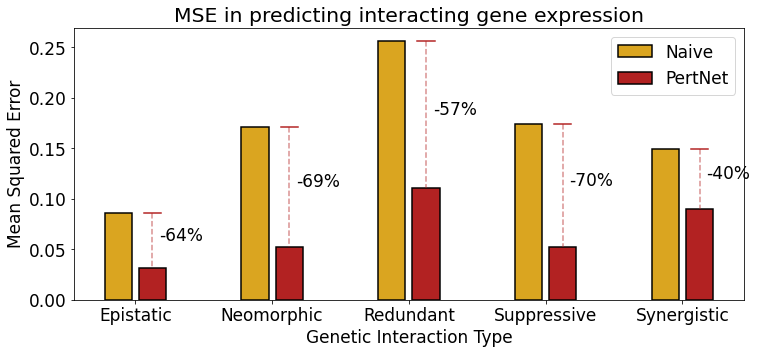

In [19]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

plot_df = pertnet_df[pertnet_df['GI_type']!='additive']
plot_df = plot_df.groupby('GI_type').mean(0).loc[:, ['pred_mse', 'naive_mse']]

fig = plt.figure(figsize=[12,5])
ax = plt.gca()
step = 4
xticks = []
xticklabels = []

for itr, GI in enumerate(plot_df.index):
    
    ax.bar(itr*step, plot_df.loc[GI, 'naive_mse'], edgecolor='black', 
            linewidth=1.5,  color='goldenrod')
    ax.bar(itr*step+1, plot_df.loc[GI, 'pred_mse'], edgecolor='black', 
            linewidth=1.5, color='firebrick')

plt.legend(['Naive', 'PertNet'], bbox_to_anchor=(1.0, 1.0))

for itr, GI in enumerate(plot_df.index):
    # Annotation
    line_bot = plot_df.loc[GI, 'naive_mse']
    line_top = plot_df.loc[GI, 'pred_mse']
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([itr*step+1,itr*step+1],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.5)
    plt.plot([itr*step+0.75,itr*step+1.25],[line_bot,line_bot], color='firebrick')
    plt.annotate('{0:.0f}%'.format(improve),(itr*step+1.2, text_pos))
    
    xticks.append(itr*step+0.5)
    xticklabels.append(GI)


plt.ylabel('Mean Squared Error')
plt.xlabel('Genetic Interaction Type')
plt.title('MSE in predicting interacting gene expression')

_ = plt.xticks(xticks, [ticklabel_map[x] for x in xticklabels])
#plt.ylim([0,0.28])